In [1]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
import os
import numpy as np
import json
import cv2
import pandas as pd
from detectron2.structures import BoxMode
import functools
import operator
print(torch.__version__, torch.cuda.is_available()) # 1.5.0+cu101 True
import copy
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from os import listdir
from os.path import isfile, isdir, join
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
from detectron2.data import build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()

/ext3/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


1.7.0+cu110 False


<Logger detectron2 (DEBUG)>

## Utils to read and load Image

In [2]:
def read_img(path, image_id, color, image_size=None):
    filename = f'{path}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img

# image loader, using rgb only here
def load_RGBY_image(path, image_id, image_size=None):
    red = read_img(path, image_id, "red", image_size)
    green = read_img(path, image_id, "green", image_size)
    blue = read_img(path, image_id, "blue", image_size)

    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

In [3]:
def custom_test_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    file = dataset_dict['file_name'].split('/')
    image = load_RGBY_image(data_dir, file[-1], image_size=512)
    
    image = image[:, :, ::-1] #Flip to convert to BGR
    
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    
    instances = utils.annotations_to_instances(dataset_dict['annotations'], image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    return dataset_dict

## Register Test Dataset

In [4]:
from detectron2.data.datasets import register_coco_instances

data_dir = '../../data/train'
register_coco_instances("hpa_train", {}, "../data/train_coco.json",data_dir )
register_coco_instances("hpa_test", {}, "../data/test_coco.json", data_dir )


In [6]:
test_metadata = MetadataCatalog.get("hpa_test")
dataset_dicts_test= DatasetCatalog.get("hpa_test")
test_metadata.thing_classes

[05/10 12:05:03 d2.data.datasets.coco]: Loading ../data/test_coco.json takes 6.87 seconds.
[05/10 12:05:03 d2.data.datasets.coco]: Loaded 2083 images in COCO format from ../data/test_coco.json


['Nucleoplasm',
 'Nuclear membrane',
 'Nucleoli',
 'Nucleoli fibrillar center',
 'Nuclear speckles',
 'Nuclear bodies',
 'Endoplasmic reticulum',
 'Golgi apparatus',
 'Intermediate filaments',
 'Actin filaments',
 'Microtubules',
 'Mitotic spindle',
 'Centrosome',
 'Plasma membrane',
 'Mitochondria',
 'Aggresome',
 'Cytosol',
 'Vesicles and punctate cytosolic patterns',
 'Negative']

## Setup Model Configuration 

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("hpa_train",)
cfg.DATASETS.TEST = ("hpa_test",)
cfg.DATALOADER.NUM_WORKERS = 10
cfg.INPUT.MIN_SIZE_TRAIN = (512,)
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.WARMUP_ITERS = 500

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 19
cfg.TEST.EVAL_PERIOD = 1000


## Run Inference to evaluate on COCO metrics

In [23]:
cfg.MODEL.WEIGHTS = os.path.join('./output/single_resnext/', "model_0019999.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001  # set the testing threshold for this model

#Call the COCO Evaluator function and pass the Validation Dataset
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("hpa_test", output_dir='./detectron_code/output/resnext101/test')
test_loader = build_detection_test_loader(cfg, "hpa_test", mapper=custom_test_mapper)

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, test_loader, evaluator)

[05/03 19:56:19 d2.data.datasets.coco]: Loading ../data/test_coco.json takes 7.48 seconds.
[05/03 19:56:19 d2.data.datasets.coco]: Loaded 2083 images in COCO format from ../data/test_coco.json
[05/03 19:56:19 d2.data.common]: Serializing 2083 elements to byte tensors and concatenating them all ...
[05/03 19:56:20 d2.data.common]: Serialized dataset takes 310.64 MiB
[05/03 19:56:20 d2.evaluation.evaluator]: Start inference on 2083 images
[05/03 19:56:24 d2.evaluation.evaluator]: Inference done 11/2083. 0.0599 s / img. ETA=0:04:30
[05/03 19:56:29 d2.evaluation.evaluator]: Inference done 51/2083. 0.0578 s / img. ETA=0:04:17
[05/03 19:56:34 d2.evaluation.evaluator]: Inference done 91/2083. 0.0579 s / img. ETA=0:04:12
[05/03 19:56:39 d2.evaluation.evaluator]: Inference done 133/2083. 0.0575 s / img. ETA=0:04:02
[05/03 19:56:44 d2.evaluation.evaluator]: Inference done 174/2083. 0.0575 s / img. ETA=0:03:57
[05/03 19:56:49 d2.evaluation.evaluator]: Inference done 213/2083. 0.0576 s / img. ETA=

OrderedDict([('bbox',
              {'AP': 46.8298717606866,
               'AP50': 63.31560967496673,
               'AP75': 52.1454516654386,
               'APs': 30.57205964601113,
               'APm': 48.75711983181992,
               'APl': 48.94143179706828,
               'AP-Nucleoplasm': 55.290225798958645,
               'AP-Nuclear membrane': 60.962955719632376,
               'AP-Nucleoli': 54.03825066948568,
               'AP-Nucleoli fibrillar center': 57.52713220105126,
               'AP-Nuclear speckles': 62.42019456982176,
               'AP-Nuclear bodies': 45.241544064450096,
               'AP-Endoplasmic reticulum': 41.179701650429344,
               'AP-Golgi apparatus': 54.382710299072265,
               'AP-Intermediate filaments': 52.16627344199114,
               'AP-Actin filaments': 43.91886075064769,
               'AP-Microtubules': 67.92229762511552,
               'AP-Mitotic spindle': nan,
               'AP-Centrosome': 39.46401839408459,
         

In [9]:
datadict_test = DatasetCatalog.get("hpa_test")
test_loader = build_detection_test_loader(cfg, "hpa_test", mapper=custom_test_mapper)

[05/10 12:05:46 d2.data.datasets.coco]: Loading ../data/test_coco.json takes 8.79 seconds.
[05/10 12:05:46 d2.data.datasets.coco]: Loaded 2083 images in COCO format from ../data/test_coco.json
[05/10 12:05:55 d2.data.datasets.coco]: Loading ../data/test_coco.json takes 8.54 seconds.
[05/10 12:05:55 d2.data.datasets.coco]: Loaded 2083 images in COCO format from ../data/test_coco.json
[05/10 12:05:55 d2.data.build]: Distribution of instances among all 19 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  Nucleoplasm  | 7324         | Nuclear mem.. | 963          |   Nucleoli    | 2226         |
| Nucleoli fi.. | 2415         | Nuclear spe.. | 3513         | Nuclear bod.. | 2939         |
| Endoplasmic.. | 2093         | Golgi appar.. | 3651         | Intermediat.. | 2322         |
| Actin filam.. | 1034         | Microtubules  | 1425   

## Visualize Segmentation Masks

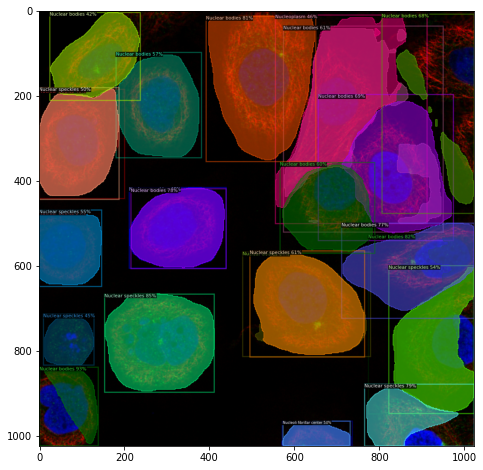

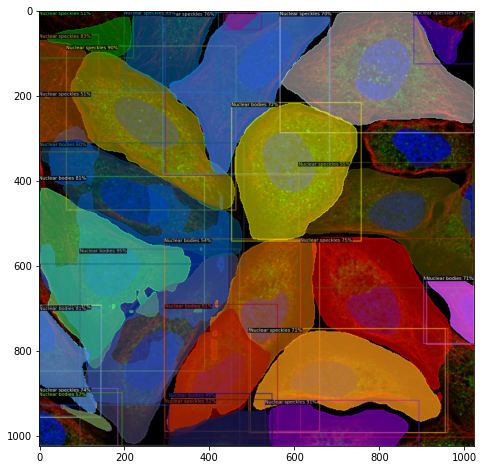

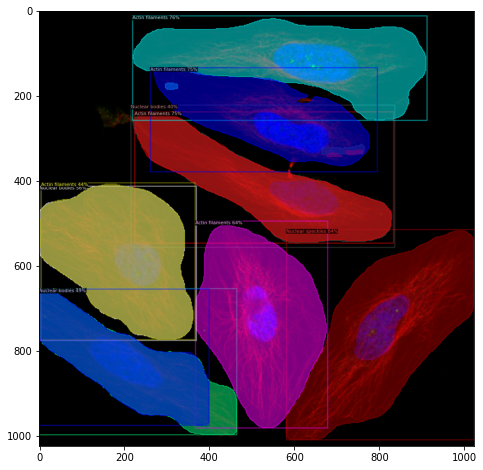

In [12]:
from detectron2.utils.visualizer import ColorMode
import random
from matplotlib.pyplot import figure

cfg.MODEL.DEVICE='cpu'
cfg.MODEL.WEIGHTS = os.path.join('./output/single_resnext/', "model_0019999.pth") #RESNEXT101 - FPN

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
#Pass the validation dataset

#Call the COCO Evaluator function and pass the Validation Dataset
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
import random
from PIL import Image
from matplotlib.pyplot import figure
import torch.nn as nn
import cv2

for d in datadict_test[45:48]: 
    img_id = d['file_name'].split("/")[-1]
    ori_img = load_RGBY_image("../../data/train", img_id)
    w,h,_ = ori_img.shape
    img= cv2.resize(ori_img, (512, 512))
    
    transform_list = [
                          T.Resize((w,h))
                      ]
    upsample = nn.Upsample(size =ori_img.shape, mode='nearest')
    image, transforms = T.apply_transform_gens(transform_list, img)
    outputs = predictor(img)
    
    v = Visualizer(image,
                   metadata=test_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION  
    )
   
    masks = []

    for i in range(len(outputs['instances'].pred_masks)):
        shape = outputs['instances'].pred_masks[i].shape
        mask = cv2.resize(np.float32(outputs['instances'].pred_masks[i].cpu().numpy()), (w,h), cv2.INTER_NEAREST)
        new_shape = mask.shape
        masks.append(torch.tensor(mask, dtype=torch.bool))

    outputs['instances']._image_size = (w,h)
    outputs['instances'].pred_masks = torch.stack([m for m in masks], dim=0)
   
    outputs['instances'].pred_boxes.scale(float(w/512),float(h/512))
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
   
    plt.figure(figsize=(8,8))
    plt.imshow(out.get_image())